In [1]:
## Importing important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb

In [2]:
# Loading the Excel file
train = pd.read_csv("train.csv")
test = pd.read_csv("test_8gqdJqH.csv")
transactions = pd.read_csv("transactions.csv")

In [3]:

train['doj'] = pd.to_datetime(train['doj'])
transactions['doj'] = pd.to_datetime(transactions['doj'])

train_full = transactions[transactions['dbd'].between(0, 30)].copy()

# Merge final seatcount target
train_full = train_full.merge(train, on=['doj', 'srcid', 'destid'], how='inner')


In [4]:
# 2. Feature Engineering
# ---------------------------
train_full['doj_day'] = train_full['doj'].dt.day
train_full['doj_weekday'] = train_full['doj'].dt.weekday
train_full['doj_month'] = train_full['doj'].dt.month
train_full['doj_is_weekend'] = train_full['doj_weekday'].isin([5, 6]).astype(int)

# Log transformation for stability
train_full['log_cumsum_seatcount'] = np.log1p(train_full['cumsum_seatcount'])
train_full['log_cumsum_searchcount'] = np.log1p(train_full['cumsum_searchcount'])
train_full['booking_intensity'] = train_full['cumsum_seatcount'] / (train_full['cumsum_searchcount'] + 1)

In [5]:
features = [
    'srcid', 'destid', 'doj_day', 'doj_weekday', 'doj_month',
    'doj_is_weekend', 'log_cumsum_seatcount', 'log_cumsum_searchcount',
    'booking_intensity'  # Add other engineered features
]


X = train_full[features]
y = train_full['final_seatcount']

In [6]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=10,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, np.log1p(y_train))
val_preds = np.expm1(model.predict(X_val))

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R2: {r2:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 1666560, number of used features: 9
[LightGBM] [Info] Start training from score 7.434467
Validation RMSE: 559.96
Validation R2: 0.7811


In [7]:
Q1 = train_full['final_seatcount'].quantile(0.25)
Q3 = train_full['final_seatcount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Outliers below {lower_bound}, above {upper_bound}")

Outliers below -482.0, above 4142.0


In [8]:
train_clean = train_full[(train_full['final_seatcount'] >= lower_bound) & (train_full['final_seatcount'] <= upper_bound)]

In [9]:
X = train_full[features]
y = train_full['final_seatcount']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, np.log1p(y_train))
val_preds = np.expm1(model.predict(X_val))

print("New RMSE:", np.sqrt(mean_squared_error(y_val, val_preds)))
print("New R²:", r2_score(y_val, val_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 1666560, number of used features: 9
[LightGBM] [Info] Start training from score 7.434467
New RMSE: 559.962689260778
New R²: 0.7811429169946631


In [10]:
train_clean.shape

(1954829, 19)

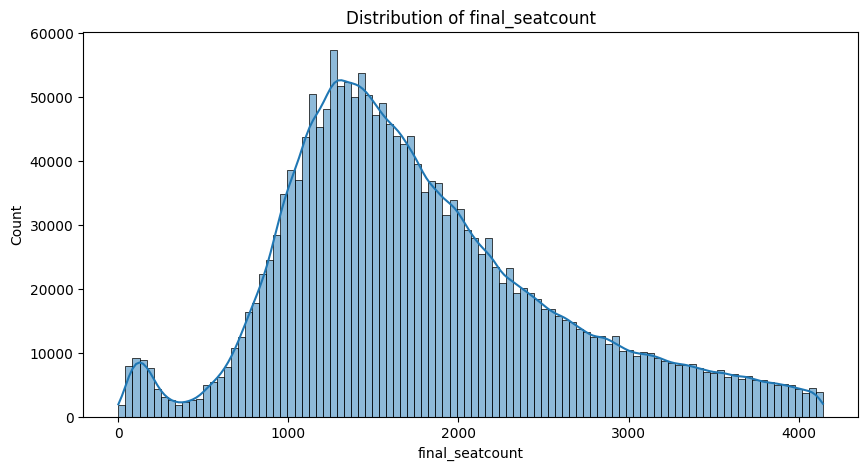

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(train_clean['final_seatcount'], bins=100, kde=True)
plt.title("Distribution of final_seatcount")
plt.show()

In [11]:
# ---------------------------
# 5. Predict on test dbd = 15
# ---------------------------
test_15 = transactions[transactions['dbd'] == 15].copy()
test_15['doj'] = pd.to_datetime(test_15['doj'])

# Apply same features
test_15['doj_day'] = test_15['doj'].dt.day
test_15['doj_weekday'] = test_15['doj'].dt.weekday
test_15['doj_month'] = test_15['doj'].dt.month
test_15['doj_is_weekend'] = test_15['doj_weekday'].isin([5, 6]).astype(int)
test_15['log_cumsum_seatcount'] = np.log1p(test_15['cumsum_seatcount'])
test_15['log_cumsum_searchcount'] = np.log1p(test_15['cumsum_searchcount'])
test_15['booking_intensity'] = test_15['cumsum_seatcount'] / (test_15['cumsum_searchcount'] + 1)


In [ ]:
# Predict
final_preds = np.expm1(model.predict(test_15[features]))
test_15['final_seatcount'] = final_preds

# Output submission file
submission = test_15[['route_key', 'final_seatcount']]
submission.to_csv('submission.csv', index=False)
print("✅ Submission file saved.")